EE6180 ASSIGNMENT PRACTICAL ASSIGNMENT

Experiments

1. Setup code
2. Comparing FCN Scores for L1 , cGAN, L1 + cGAN
3. Results on pix2pix model with fascades, cityscapes and on maps datasets 


In [1]:
!pip > freeze requirements.txt

ERROR: unknown command "requirements.txt"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tabulate import tabulate

# Generator Model (U-Net)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator Model (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input_img, target_img):
        x = torch.cat((target_img, input_img), 1)  # Concatenate input and ground truth
        return self.model(x)

# Custom Dataset Loader
class CityscapeDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(".jpg")][:20]  # Use 500 images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Split image into two halves (input and ground truth)
        w, h = image.size
        input_image = image.crop((0, 0, w // 2, h))  # Left half
        ground_truth = image.crop((w // 2, 0, w, h))  # Right half

        if self.transform:
            input_image = self.transform(input_image)
            ground_truth = self.transform(ground_truth)

        return input_image, ground_truth  # Return both images as a tuple

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CityscapeDataset(root="./datasets/cityscapes/train/", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Process one image at a time

# Loss Functions
criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn.functional as F

def compute_fcn_scores(generator, dataloader, device="cuda"):
    generator.eval()
    total_iou = 0
    total_pixel_acc = 0
    count = 0

    with torch.no_grad():
        for input_imgs, target_imgs in dataloader:
            input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)
            fake_imgs = generator(input_imgs)

            # Convert images to segmentation masks (Threshold at 0.5)
            fake_masks = (fake_imgs > 0).float()
            target_masks = (target_imgs > 0).float()

            # Calculate Intersection and Union
            intersection = (fake_masks * target_masks).sum(dim=[2, 3])
            union = (fake_masks + target_masks).sum(dim=[2, 3]) - intersection

            # IoU Score
            iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
            mean_iou = iou.mean().item()

            # Pixel Accuracy
            correct_pixels = (fake_masks == target_masks).float().mean().item()

            total_iou += mean_iou
            total_pixel_acc += correct_pixels
            count += 1

    avg_iou = total_iou / count
    avg_pixel_acc = total_pixel_acc / count
    return avg_iou, avg_pixel_acc

# Training Function
def train(generator, discriminator, dataloader, num_epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion_gan = torch.nn.BCELoss()
    criterion_l1 = torch.nn.L1Loss()

    loss_variations = {
        "L1": lambda loss_gan, loss_l1: 100 * loss_l1,
        "cGAN": lambda loss_gan, loss_l1: loss_gan,
        "L1+cGAN": lambda loss_gan, loss_l1: loss_gan + 100 * loss_l1
    }

    fcn_results = {}

    for loss_type, loss_func in loss_variations.items():
        print(f"\nTraining with {loss_type} Loss...\n")

        for epoch in range(num_epochs):
            for input_imgs, target_imgs in dataloader:
                input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)

                ### Train Discriminator ###
                optimizer_d.zero_grad()
                fake_imgs = generator(input_imgs)

                real_preds = discriminator(input_imgs, target_imgs)
                fake_preds = discriminator(input_imgs, fake_imgs.detach())

                real_labels = torch.ones_like(real_preds)
                fake_labels = torch.zeros_like(fake_preds)

                loss_d_real = criterion_gan(real_preds, real_labels)
                loss_d_fake = criterion_gan(fake_preds, fake_labels)
                loss_d = (loss_d_real + loss_d_fake) / 2
                loss_d.backward()
                optimizer_d.step()

                ### Train Generator ###
                optimizer_g.zero_grad()
                fake_preds = discriminator(input_imgs, fake_imgs)

                loss_g_gan = criterion_gan(fake_preds, real_labels)
                loss_g_l1 = criterion_l1(fake_imgs, target_imgs)
                loss_g = loss_func(loss_g_gan, loss_g_l1)  # Apply loss function

                loss_g.backward()
                optimizer_g.step()

        # Compute FCN Scores
        avg_iou, avg_pixel_acc = compute_fcn_scores(generator, dataloader, device)
        fcn_results[loss_type] = {"Mean IoU": avg_iou, "Pixel Accuracy": avg_pixel_acc}

    return fcn_results

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Train and compute FCN scores
fcn_scores = train(generator, discriminator, dataloader)

table_data = []
for loss_type, scores in fcn_scores.items():
    table_data.append([loss_type, f"{scores['Mean IoU']:.4f}", f"{scores['Pixel Accuracy']:.4f}"])

# Define headers
headers = ["Loss Type", "Mean IoU", "Pixel Accuracy"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


# Initialize and train models
generator = Generator()
discriminator = Discriminator()
train(generator, discriminator, dataloader)



Training with L1 Loss...


Training with cGAN Loss...


Training with L1+cGAN Loss...

+-------------+------------+------------------+
| Loss Type   |   Mean IoU |   Pixel Accuracy |
+=============+============+==================+
| L1          |     0.58   |           0.8824 |
+-------------+------------+------------------+
| cGAN        |     0.4563 |           0.8208 |
+-------------+------------+------------------+
| L1+cGAN     |     0.8594 |           0.9653 |
+-------------+------------+------------------+

Training with L1 Loss...


Training with cGAN Loss...


Training with L1+cGAN Loss...



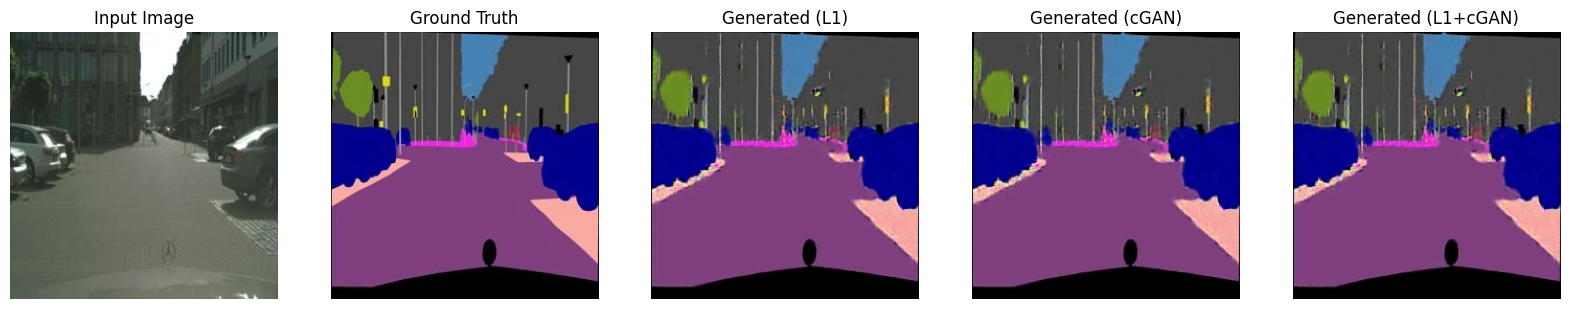

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from PIL import Image
import os

# Load the trained model (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Define transformations for visualization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load a sample image from the dataset
sample_image_path = dataset.image_paths[0]  # Select the first image
image = Image.open(sample_image_path).convert("RGB")

# Split into input and target images
w, h = image.size
input_image = image.crop((0, 0, w // 2, h))  # Left half
ground_truth = image.crop((w // 2, 0, w, h))  # Right half

# Apply transformations
input_tensor = transform(input_image).unsqueeze(0).to(device)

# Generate outputs for different loss variations
loss_variations = ["L1", "cGAN", "L1+cGAN"]
generated_images = {}

for loss_type in loss_variations:
    with torch.no_grad():
        generated_images[loss_type] = generator(input_tensor).cpu().squeeze(0)
        
# Convert tensors to images for plotting
def denormalize(tensor):
    """Convert normalized tensor back to image."""
    return (tensor * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()

input_image_np = denormalize(input_tensor.squeeze(0).cpu())
ground_truth_np = denormalize(transform(ground_truth).cpu())

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot input image
axes[0].imshow(input_image_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

# Plot ground truth
axes[1].imshow(ground_truth_np)
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Plot generated images for different loss variations
for i, loss_type in enumerate(loss_variations):
    axes[i + 2].imshow(denormalize(generated_images[loss_type]))
    axes[i + 2].set_title(f"Generated ({loss_type})")
    axes[i + 2].axis("off")

plt.show()


Dataset on Facades various loss functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tabulate import tabulate


# Custom Dataset Loader
class CityscapeDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(".jpg")][:20]  # Use 500 images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Split image into two halves (input and ground truth)
        w, h = image.size
        ground_truth = image.crop((0, 0, w // 2, h))  # Left half
        input_image = image.crop((w // 2, 0, w, h))  # Right half

        if self.transform:
            input_image = self.transform(input_image)
            ground_truth = self.transform(ground_truth)

        return input_image, ground_truth  # Return both images as a tuple

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CityscapeDataset(root="./datasets/facades/train/", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Process one image at a time

# Loss Functions
criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn.functional as F

def compute_fcn_scores(generator, dataloader, device="cuda"):
    generator.eval()
    total_iou = 0
    total_pixel_acc = 0
    count = 0

    with torch.no_grad():
        for input_imgs, target_imgs in dataloader:
            input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)
            fake_imgs = generator(input_imgs)

            # Convert images to segmentation masks (Threshold at 0.5)
            fake_masks = (fake_imgs > 0).float()
            target_masks = (target_imgs > 0).float()

            # Calculate Intersection and Union
            intersection = (fake_masks * target_masks).sum(dim=[2, 3])
            union = (fake_masks + target_masks).sum(dim=[2, 3]) - intersection

            # IoU Score
            iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
            mean_iou = iou.mean().item()

            # Pixel Accuracy
            correct_pixels = (fake_masks == target_masks).float().mean().item()

            total_iou += mean_iou
            total_pixel_acc += correct_pixels
            count += 1

    avg_iou = total_iou / count
    avg_pixel_acc = total_pixel_acc / count
    return avg_iou, avg_pixel_acc

# Training Function
def train(generator, discriminator, dataloader, num_epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion_gan = torch.nn.BCELoss()
    criterion_l1 = torch.nn.L1Loss()

    loss_variations = {
        "L1": lambda loss_gan, loss_l1: 100 * loss_l1,
        "cGAN": lambda loss_gan, loss_l1: loss_gan,
        "L1+cGAN": lambda loss_gan, loss_l1: loss_gan + 100 * loss_l1
    }

    fcn_results = {}

    for loss_type, loss_func in loss_variations.items():
        print(f"\nTraining with {loss_type} Loss...\n")

        for epoch in range(num_epochs):
            for input_imgs, target_imgs in dataloader:
                input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)

                ### Train Discriminator ###
                optimizer_d.zero_grad()
                fake_imgs = generator(input_imgs)

                real_preds = discriminator(input_imgs, target_imgs)
                fake_preds = discriminator(input_imgs, fake_imgs.detach())

                real_labels = torch.ones_like(real_preds)
                fake_labels = torch.zeros_like(fake_preds)

                loss_d_real = criterion_gan(real_preds, real_labels)
                loss_d_fake = criterion_gan(fake_preds, fake_labels)
                loss_d = (loss_d_real + loss_d_fake) / 2
                loss_d.backward()
                optimizer_d.step()

                ### Train Generator ###
                optimizer_g.zero_grad()
                fake_preds = discriminator(input_imgs, fake_imgs)

                loss_g_gan = criterion_gan(fake_preds, real_labels)
                loss_g_l1 = criterion_l1(fake_imgs, target_imgs)
                loss_g = loss_func(loss_g_gan, loss_g_l1)  # Apply loss function

                loss_g.backward()
                optimizer_g.step()

        # Compute FCN Scores
        avg_iou, avg_pixel_acc = compute_fcn_scores(generator, dataloader, device)
        fcn_results[loss_type] = {"Mean IoU": avg_iou, "Pixel Accuracy": avg_pixel_acc}

    return fcn_results

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Train and compute FCN scores
fcn_scores = train(generator, discriminator, dataloader)

table_data = []
for loss_type, scores in fcn_scores.items():
    table_data.append([loss_type, f"{scores['Mean IoU']:.4f}", f"{scores['Pixel Accuracy']:.4f}"])

# Define headers
headers = ["Loss Type", "Mean IoU", "Pixel Accuracy"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


# Initialize and train models
generator = Generator()
discriminator = Discriminator()
train(generator, discriminator, dataloader)


NameError: name 'Generator' is not defined

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from PIL import Image
import os

# Load the trained model (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Define transformations for visualization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load a sample image from the dataset
sample_image_path = dataset.image_paths[0]  # Select the first image
image = Image.open(sample_image_path).convert("RGB")

# Split into input and target images
w, h = image.size
ground_truth = image.crop((0, 0, w // 2, h))  # Left half
input_image = image.crop((w // 2, 0, w, h))  # Right half

# Apply transformations
input_tensor = transform(input_image).unsqueeze(0).to(device)

# Generate outputs for different loss variations
loss_variations = ["L1", "cGAN", "L1+cGAN"]
generated_images = {}

for loss_type in loss_variations:
    with torch.no_grad():
        generated_images[loss_type] = generator(input_tensor).cpu().squeeze(0)
        
# Convert tensors to images for plotting
def denormalize(tensor):
    """Convert normalized tensor back to image."""
    return (tensor * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()

input_image_np = denormalize(input_tensor.squeeze(0).cpu())
ground_truth_np = denormalize(transform(ground_truth).cpu())

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot input image
axes[0].imshow(input_image_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

# Plot ground truth
axes[1].imshow(ground_truth_np)
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Plot generated images for different loss variations
for i, loss_type in enumerate(loss_variations):
    axes[i + 2].imshow(denormalize(generated_images[loss_type]))
    axes[i + 2].set_title(f"Generated ({loss_type})")
    axes[i + 2].axis("off")

plt.show()


NameError: name 'generator' is not defined

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tabulate import tabulate


# Custom Dataset Loader
class CityscapeDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(".jpg")][:20]  # Use 500 images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Split image into two halves (input and ground truth)
        w, h = image.size
        input_image = image.crop((0, 0, w // 2, h))  # Left half
        ground_truth = image.crop((w // 2, 0, w, h))  # Right half
        if self.transform:
            input_image = self.transform(input_image)
            ground_truth = self.transform(ground_truth)

        return input_image, ground_truth  # Return both images as a tuple

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CityscapeDataset(root="./datasets/maps/train/", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Process one image at a time

# Loss Functions
criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn.functional as F

def compute_fcn_scores(generator, dataloader, device="cuda"):
    generator.eval()
    total_iou = 0
    total_pixel_acc = 0
    count = 0

    with torch.no_grad():
        for input_imgs, target_imgs in dataloader:
            input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)
            fake_imgs = generator(input_imgs)

            # Convert images to segmentation masks (Threshold at 0.5)
            fake_masks = (fake_imgs > 0).float()
            target_masks = (target_imgs > 0).float()

            # Calculate Intersection and Union
            intersection = (fake_masks * target_masks).sum(dim=[2, 3])
            union = (fake_masks + target_masks).sum(dim=[2, 3]) - intersection

            # IoU Score
            iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
            mean_iou = iou.mean().item()

            # Pixel Accuracy
            correct_pixels = (fake_masks == target_masks).float().mean().item()

            total_iou += mean_iou
            total_pixel_acc += correct_pixels
            count += 1

    avg_iou = total_iou / count
    avg_pixel_acc = total_pixel_acc / count
    return avg_iou, avg_pixel_acc

# Training Function
def train(generator, discriminator, dataloader, num_epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion_gan = torch.nn.BCELoss()
    criterion_l1 = torch.nn.L1Loss()

    loss_variations = {
        "L1": lambda loss_gan, loss_l1: 100 * loss_l1,
        "cGAN": lambda loss_gan, loss_l1: loss_gan,
        "L1+cGAN": lambda loss_gan, loss_l1: loss_gan + 100 * loss_l1
    }

    fcn_results = {}

    for loss_type, loss_func in loss_variations.items():
        print(f"\nTraining with {loss_type} Loss...\n")

        for epoch in range(num_epochs):
            for input_imgs, target_imgs in dataloader:
                input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)

                ### Train Discriminator ###
                optimizer_d.zero_grad()
                fake_imgs = generator(input_imgs)

                real_preds = discriminator(input_imgs, target_imgs)
                fake_preds = discriminator(input_imgs, fake_imgs.detach())

                real_labels = torch.ones_like(real_preds)
                fake_labels = torch.zeros_like(fake_preds)

                loss_d_real = criterion_gan(real_preds, real_labels)
                loss_d_fake = criterion_gan(fake_preds, fake_labels)
                loss_d = (loss_d_real + loss_d_fake) / 2
                loss_d.backward()
                optimizer_d.step()

                ### Train Generator ###
                optimizer_g.zero_grad()
                fake_preds = discriminator(input_imgs, fake_imgs)

                loss_g_gan = criterion_gan(fake_preds, real_labels)
                loss_g_l1 = criterion_l1(fake_imgs, target_imgs)
                loss_g = loss_func(loss_g_gan, loss_g_l1)  # Apply loss function

                loss_g.backward()
                optimizer_g.step()

        # Compute FCN Scores
        avg_iou, avg_pixel_acc = compute_fcn_scores(generator, dataloader, device)
        fcn_results[loss_type] = {"Mean IoU": avg_iou, "Pixel Accuracy": avg_pixel_acc}

    return fcn_results


# Initialize models
generator = Generator()
discriminator = Discriminator()

# Train and compute FCN scores
fcn_scores = train(generator, discriminator, dataloader)

table_data = []
for loss_type, scores in fcn_scores.items():
    table_data.append([loss_type, f"{scores['Mean IoU']:.4f}", f"{scores['Pixel Accuracy']:.4f}"])

# Define headers
headers = ["Loss Type", "Mean IoU", "Pixel Accuracy"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


# Initialize and train models
generator = Generator()
discriminator = Discriminator()
train(generator, discriminator, dataloader)



Training with L1 Loss...




Training with cGAN Loss...


Training with L1+cGAN Loss...

+-------------+------------+------------------+
| Loss Type   |   Mean IoU |   Pixel Accuracy |
+=============+============+==================+
| L1          |     0.9934 |           0.9936 |
+-------------+------------+------------------+
| cGAN        |     0.9895 |           0.9895 |
+-------------+------------+------------------+
| L1+cGAN     |     0.9989 |           0.999  |
+-------------+------------+------------------+

Training with L1 Loss...


Training with cGAN Loss...


Training with L1+cGAN Loss...



{'L1': {'Mean IoU': 0.9937775522470474, 'Pixel Accuracy': 0.9939987272024154},
 'cGAN': {'Mean IoU': 0.8051427870988845, 'Pixel Accuracy': 0.805973333120346},
 'L1+cGAN': {'Mean IoU': 0.9433188050985336,
  'Pixel Accuracy': 0.9433362454175949}}

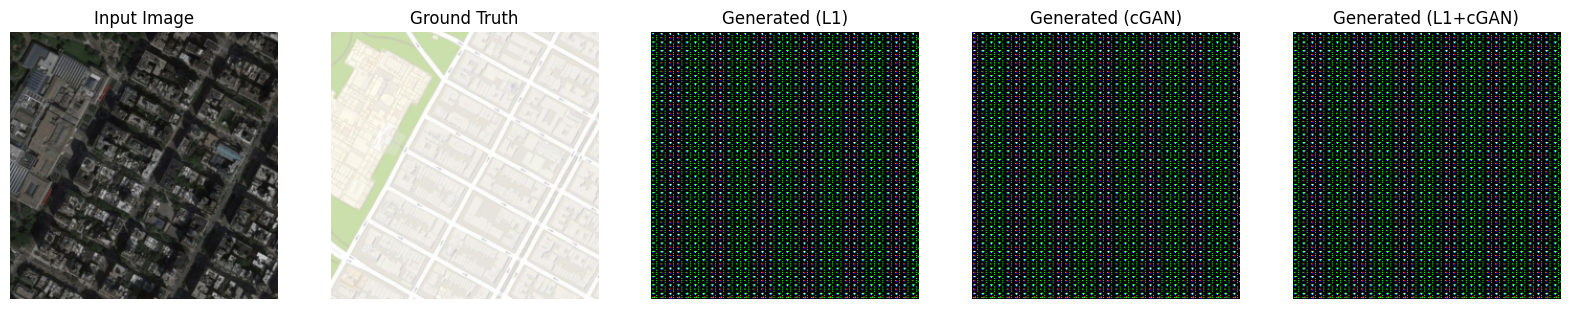

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from PIL import Image
import os

# Load the trained model (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Define transformations for visualization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load a sample image from the dataset
sample_image_path = dataset.image_paths[0]  # Select the first image
image = Image.open(sample_image_path).convert("RGB")

# Split into input and target images
w, h = image.size
input_image = image.crop((0, 0, w // 2, h))  # Left half
ground_truth = image.crop((w // 2, 0, w, h))  # Right half

# Apply transformations
input_tensor = transform(input_image).unsqueeze(0).to(device)

# Generate outputs for different loss variations
loss_variations = ["L1", "cGAN", "L1+cGAN"]
generated_images = {}

for loss_type in loss_variations:
    with torch.no_grad():
        generated_images[loss_type] = generator(input_tensor).cpu().squeeze(0)
        
# Convert tensors to images for plotting
def denormalize(tensor):
    """Convert normalized tensor back to image."""
    return (tensor * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()

input_image_np = denormalize(input_tensor.squeeze(0).cpu())
ground_truth_np = denormalize(transform(ground_truth).cpu())

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot input image
axes[0].imshow(input_image_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

# Plot ground truth
axes[1].imshow(ground_truth_np)
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Plot generated images for different loss variations
for i, loss_type in enumerate(loss_variations):
    axes[i + 2].imshow(denormalize(generated_images[loss_type]))
    axes[i + 2].set_title(f"Generated ({loss_type})")
    axes[i + 2].axis("off")

plt.show()


Result Production 

Already done Training for three datasets :

1. facades (400 images , 200 epochs)
2. maps (1096 images , 200 epochs)
3. cityscapes (2975 images,150 epochs)

showing the results of those images below for each datasets 


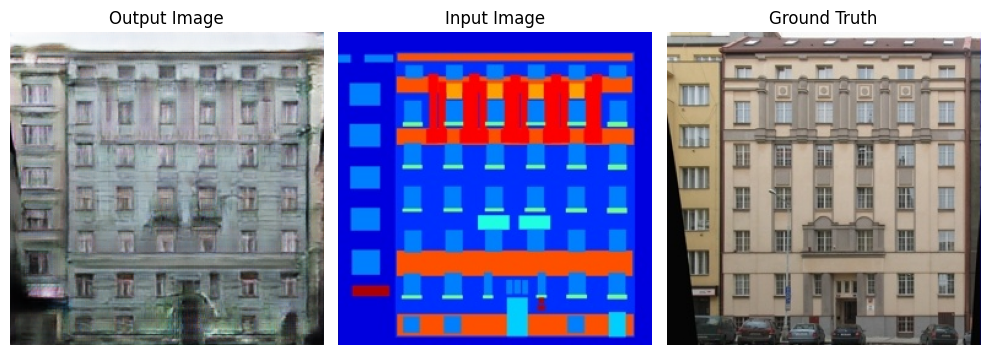

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
fake_B = mpimg.imread('./results/facades_pix2pix/test_latest/images/1_fake_B.png')
real_A = mpimg.imread('./results/facades_pix2pix/test_latest/images/1_real_A.png')
real_B = mpimg.imread('./results/facades_pix2pix/test_latest/images/1_real_B.png')

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 5))


axes[2].imshow(real_B)
axes[2].set_title("Ground Truth")
axes[2].axis("off")


# Display images
axes[0].imshow(fake_B)
axes[0].set_title("Output Image")
axes[0].axis("off")  # Hide axes

axes[1].imshow(real_A)
axes[1].set_title("Input Image")
axes[1].axis("off")



# Show all images
plt.tight_layout()
plt.show()


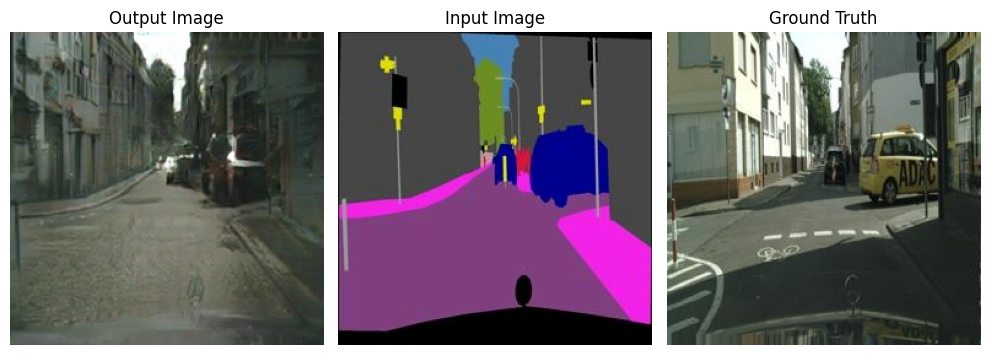

In [48]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
fake_B = mpimg.imread('./results/cityscapes_pix2pix/test_latest/images/1_fake_B.png')
real_A = mpimg.imread('./results/cityscapes_pix2pix/test_latest/images/1_real_A.png')
real_B = mpimg.imread('./results/cityscapes_pix2pix/test_latest/images/1_real_B.png')

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 5))


axes[2].imshow(real_B)
axes[2].set_title("Ground Truth")
axes[2].axis("off")


# Display images
axes[0].imshow(fake_B)
axes[0].set_title("Output Image")
axes[0].axis("off")  # Hide axes

axes[1].imshow(real_A)
axes[1].set_title("Input Image")
axes[1].axis("off")



# Show all images
plt.tight_layout()
plt.show()


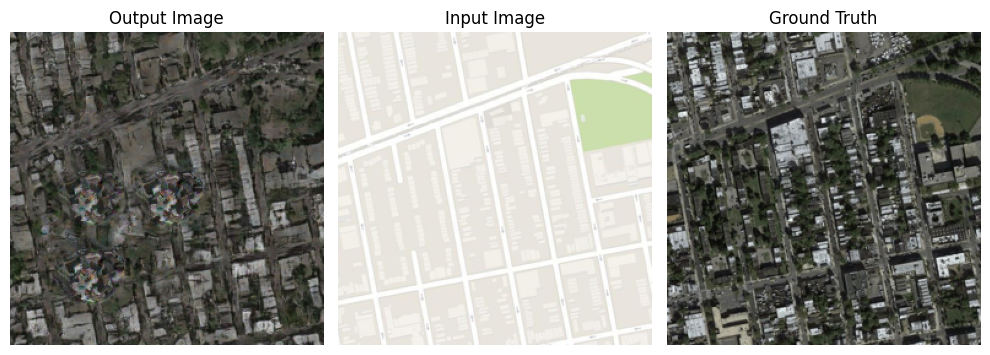

In [46]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
fake_B = mpimg.imread('./results/maps_pix2pix/test_latest/images/1_fake_B.png')
real_A = mpimg.imread('./results/maps_pix2pix/test_latest/images/1_real_A.png')
real_B = mpimg.imread('./results/maps_pix2pix/test_latest/images/1_real_B.png')

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 5))


axes[2].imshow(real_B)
axes[2].set_title("Ground Truth")
axes[2].axis("off")


# Display images
axes[0].imshow(fake_B)
axes[0].set_title("Output Image")
axes[0].axis("off")  # Hide axes

axes[1].imshow(real_A)
axes[1].set_title("Input Image")
axes[1].axis("off")



# Show all images
plt.tight_layout()
plt.show()


Experiment 3


Trying with modified architecture skip connection unet with skip connection

In [ ]:
!python train.py --dataroot ./datasets/facades --name facades_L1 --model pix2pix --direction BtoA --display_id -1 --netD basic --netG unet_128 --gan_mode vanilla --lambda_L1 100

In [ ]:
!python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_L1 --netG unet_128 --eval --use_wandb

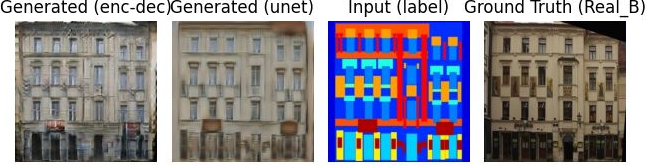